In [1]:
import tensorflow as tf

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
n_gpus = len(os.environ['CUDA_VISIBLE_DEVICES'].split(','))

import keras.backend as K
#import tensorflow as tf

# gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [3]:
import numpy as np
import pandas as pd
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.applications import *
from keras.regularizers import l2

from keras.preprocessing.image import *

import matplotlib.pyplot as plt
import random
import os
import cv2
from tqdm import tqdm
from glob import glob
import multiprocessing

from sklearn.model_selection import train_test_split
from collections import Counter
from keras import backend as K
from keras.utils import multi_gpu_model

from IPython.display import display, Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [4]:
df = pd.read_csv('data/Annotations/label.csv', header=None)
df.columns = ['filename', 'label_name', 'label']
df = df.sample(frac=1).reset_index(drop=True) # shuffle

df.label_name = df.label_name.str.replace('_labels', '')
df = df[df.label_name == 'collar_design']

display(df.head())
c = Counter(df.label_name)
c

,filename,label_name,label
2,Images/collar_design_labels/ab196ef0df2f768620...,collar_design,ynnnm
18,Images/collar_design_labels/392953ccbe181a1562...,collar_design,nnnny
21,Images/collar_design_labels/c971b3ecb2c3cbd84f...,collar_design,nnnny
23,Images/collar_design_labels/1dca5158e407a7fca8...,collar_design,nnnyn
38,Images/collar_design_labels/52090c48fff9128974...,collar_design,nnnny


Counter({'collar_design': 8393})

In [5]:
label_count = dict([(x, len(df[df.label_name == x].label.values[0])) for x in c.keys()])
label_names = list(label_count.keys())
display(label_count)

{'collar_design': 5}

In [6]:
n = len(df)
print(n)

8393


In [7]:
fnames = df['filename'].values
width = 399

y = [np.zeros((n, label_count[x])) for x in label_count.keys()]
df = df.reset_index(drop=True)

In [8]:
for i in range(n):
    label_name = df.label_name[i]
    label = df.label[i]
    y[label_names.index(label_name)][i, label.find('y')] = 1
    #y[label_names.index(label_name)][i, label.find('m')] = 0.5

In [9]:
print(fnames[0:10])
print(n)
print(len(y[0]))
print(len(y))
print(label_count.keys())
print(len(y[0][0]))

['Images/collar_design_labels/ab196ef0df2f768620a3db69ef209947.jpg'
 'Images/collar_design_labels/392953ccbe181a1562213312b6de66b7.jpg'
 'Images/collar_design_labels/c971b3ecb2c3cbd84f95263cdef2aeb0.jpg'
 'Images/collar_design_labels/1dca5158e407a7fca888b41d600f113a.jpg'
 'Images/collar_design_labels/52090c48fff91289748e2fb2dec8066b.jpg'
 'Images/collar_design_labels/aad9e1ab607be15dc63992d7b4d611ac.jpg'
 'Images/collar_design_labels/e0911e3f326e3c126461a25b19b325c8.jpg'
 'Images/collar_design_labels/ba78da694c5736a088fa69c591413fb1.jpg'
 'Images/collar_design_labels/8d6523d93e1e22cc448e213be2406292.jpg'
 'Images/collar_design_labels/977142e615cb7e3497d4f8df0a3b575c.jpg']
8393
8393
1
dict_keys(['collar_design'])
5


In [10]:
def f(index):
    if os.path.isfile('data/'+fnames[index]):
        return index, cv2.resize(cv2.imread('data/'+fnames[index]), (width, width))

X = np.zeros((n, width, width, 3), dtype=np.uint8)
with multiprocessing.Pool(12) as pool:
    with tqdm(pool.imap_unordered(f, range(n)), total=n) as pbar:
        for i, img in pbar:
            X[i] = img[:,:,::-1]

100%|██████████| 8393/8393 [00:21<00:00, 382.79it/s]


In [11]:
n_train = int(n*0.8)

X_train = X[:n_train]
X_valid = X[n_train:]
y_train = [x[:n_train] for x in y]
y_valid = [x[n_train:] for x in y]

In [12]:
from dataset import *
gen_train = Generator(X_train, y_train, batch_size=32, aug=True)

In [13]:
base_model = ResNet50(weights='imagenet', input_shape=(width, width, 3), include_top=False, pooling='avg')

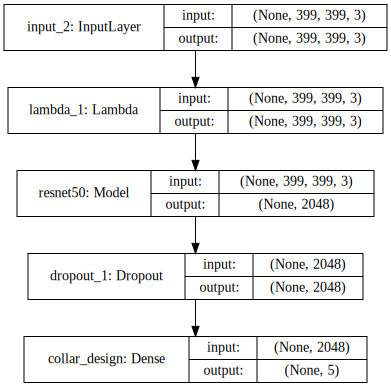

In [14]:
input_tensor = Input((width, width, 3))
x = input_tensor
x = Lambda(resnet50.preprocess_input)(x)
x = base_model(x)
x = Dropout(0.5)(x)
x = [Dense(count, activation='softmax', name=name)(x) for name, count in label_count.items()]

model = Model(input_tensor, x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

plot_model(model, show_shapes=True, to_file='model_collar_design.png')
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [15]:
model2 = multi_gpu_model(model, n_gpus)

In [16]:
model2.compile(optimizer = Adam(0.0001),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
210/210 [==============================] - 304s 1s/step - loss: 1.0597 - acc: 0.5920 - val_loss: 0.6202 - val_acc: 0.7850
Epoch 2/5
210/210 [==============================] - 260s 1s/step - loss: 0.6209 - acc: 0.7721 - val_loss: 0.6004 - val_acc: 0.8052
Epoch 3/5
210/210 [==============================] - 258s 1s/step - loss: 0.4811 - acc: 0.8217 - val_loss: 0.5646 - val_acc: 0.8017
Epoch 4/5
210/210 [==============================] - 259s 1s/step - loss: 0.3793 - acc: 0.8630 - val_loss: 0.6303 - val_acc: 0.7957
Epoch 5/5
210/210 [==============================] - 258s 1s/step - loss: 0.3253 - acc: 0.8810 - val_loss: 0.6028 - val_acc: 0.8291


In [17]:
model2.compile(optimizer = Adam(0.000025),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
210/210 [==============================] - 297s 1s/step - loss: 0.2250 - acc: 0.9214 - val_loss: 0.4663 - val_acc: 0.8553
Epoch 2/5
210/210 [==============================] - 256s 1s/step - loss: 0.1648 - acc: 0.9428 - val_loss: 0.4820 - val_acc: 0.8612
Epoch 3/5
210/210 [==============================] - 255s 1s/step - loss: 0.1390 - acc: 0.9514 - val_loss: 0.4772 - val_acc: 0.8642
Epoch 4/5
210/210 [==============================] - 257s 1s/step - loss: 0.1259 - acc: 0.9577 - val_loss: 0.5176 - val_acc: 0.8523
Epoch 5/5
210/210 [==============================] - 257s 1s/step - loss: 0.1068 - acc: 0.9635 - val_loss: 0.6116 - val_acc: 0.8446


In [18]:
model2.compile(optimizer = Adam(0.00000625),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=3, validation_data=(X_valid, y_valid))

Epoch 1/3
210/210 [==============================] - 298s 1s/step - loss: 0.0974 - acc: 0.9677 - val_loss: 0.5215 - val_acc: 0.8618
Epoch 2/3
210/210 [==============================] - 257s 1s/step - loss: 0.0765 - acc: 0.9751 - val_loss: 0.5406 - val_acc: 0.8606
Epoch 3/3
210/210 [==============================] - 255s 1s/step - loss: 0.0817 - acc: 0.9732 - val_loss: 0.5145 - val_acc: 0.8642


In [19]:
model2.compile(optimizer = Adam(0.00000425),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=1, validation_data=(X_valid, y_valid))

Epoch 1/1
210/210 [==============================] - 302s 1s/step - loss: 0.0819 - acc: 0.9711 - val_loss: 0.5138 - val_acc: 0.8672


In [20]:
model2.compile(optimizer = Adam(0.000001),loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.fit_generator(gen_train.generator, steps_per_epoch=gen_train.steps, 
                    epochs=1, validation_data=(X_valid, y_valid))

Epoch 1/1
210/210 [==============================] - 300s 1s/step - loss: 0.0652 - acc: 0.9786 - val_loss: 0.5162 - val_acc: 0.8696


In [21]:
model_name = 'resnet_collar_design'

model.save('model_%s.h5' % model_name)